This notebook is used to make Figure 6 of the manuscript: maps of EMD diagnostic comparing climatology of model to climatology of satellite.

The EMD diagnostic itself is calculated separately and stored as a netCDF file. 
*That calculation is done with `compute_save_emd.py`*

Note that other distances or divergences have been used along the way to settling on EMD. The main one I experimented with was relative entropy, aka Kullback-Liebler divergence.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
import numpy as np
import xarray as xr
import cmasher as cm
import colorcet as cc
from pathlib import Path

import computations as comp  # lonFlip

In [3]:
# files, just
# 
# 
stem = Path('/Users/brianpm/Dropbox/Projects/COSP2/') 

# Kullback-Liebler
# c4_misr = xr.open_dataset(stem / 'cam4_misr_histogram_error_c20221121.nc')
# c5_misr = xr.open_dataset(stem / 'cam5_misr_histogram_error_c20221121.nc')
# c6_misr = xr.open_dataset(stem / 'cam6_misr_histogram_error_c20221121.nc')

# c4_modis = xr.open_dataset(stem / 'cam4_modis_post2000_histogram_error_c20221121.nc')
# c5_modis = xr.open_dataset(stem / 'cam5_modis_post2000_histogram_error_c20221121.nc')
# c6_modis = xr.open_dataset(stem / 'cam6_modis_post2000_histogram_error_c20221121.nc')

# c4_isccp = xr.open_dataset(stem / 'cam4_isccp_post2000_histogram_error_c20221121.nc')
# c5_isccp = xr.open_dataset(stem / 'cam5_isccp_post2000_histogram_error_c20221121.nc')
# c6_isccp = xr.open_dataset(stem / 'cam6_isccp_post2000_histogram_error_c20221121.nc')
# e3_isccp = xr.open_dataset(stem / 'e3sm_isccp_post2000_histogram_error_c20221121.nc')

# Earth Mover's Distance
c4_misr = xr.open_dataset(stem / 'cam4_misr_2001-2020_emd_nanversion.nc')
c5_misr = xr.open_dataset(stem / 'cam5_misr_2001-2020_emd_nanversion.nc')
c6_misr = xr.open_dataset(stem / 'cam6_misr_2001-2020_emd_nanversion.nc')

c4_modis = xr.open_dataset(stem / 'cam4_modis_2002-2022_emd_nanversion.nc')
c5_modis = xr.open_dataset(stem / 'cam5_modis_2002-2022_emd_nanversion.nc')
c6_modis = xr.open_dataset(stem / 'cam6_modis_2002-2022_emd_nanversion.nc')

c4_isccp = xr.open_dataset(stem / 'cam4_isccp_2000-2016_emd_nanversion.nc')
c5_isccp = xr.open_dataset(stem / 'cam5_isccp_2000-2016_emd_nanversion.nc')
c6_isccp = xr.open_dataset(stem / 'cam6_isccp_2000-2016_emd_nanversion.nc')
e3_isccp = xr.open_dataset(stem / 'e3sm_isccp_2000-2016_emd_nanversion.nc')



In [4]:
#
# Get the OMEGA500 climatology to go along
#
c4_w5_ds = comp.open_cesm_dataset("/Volumes/Drudonna/cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.OMEGA500.200011-201012.nc")
c4_w5 = c4_w5_ds['OMEGA500'].sel(time=slice('2001-01-01',None))
c4_w5 = c4_w5.weighted(c4_w5.time.dt.daysinmonth).mean(dim='time', keep_attrs=True)

c5_w5_ds = comp.open_cesm_dataset("/Volumes/Drudonna/cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.OMEGA500.200101-201012.nc")
c5_w5 = c5_w5_ds['OMEGA500'].sel(time=slice('2001-01-01',None))
c5_w5 = c5_w5.weighted(c5_w5.time.dt.daysinmonth).mean(dim='time', keep_attrs=True)

c6_w5_ds = comp.open_cesm_dataset("/Volumes/Drudonna/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.OMEGA500.197901-201412.nc")
c6_w5 = c6_w5_ds['OMEGA500'].sel(time=slice('2001-01-01',None))
c6_w5 = c6_w5.weighted(c6_w5.time.dt.daysinmonth).mean(dim='time', keep_attrs=True)

e3_w5_ds = xr.open_dataset("/Volumes/Drudonna/E3SM-1-0_amip/remapped/wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_199501-201412.nc").sel(time=slice('2001-01-01',None),plev=50000)
e3_w5 = e3_w5_ds['wap'].weighted(e3_w5_ds.time.dt.daysinmonth).mean(dim='time', keep_attrs=True)
e3_w5.name = "OMEGA500"



In [5]:
landfrac = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC'].squeeze()
c4_w5 = comp.rm_land(c4_w5, landfrac)
c5_w5 = comp.rm_land(c5_w5, landfrac)
c6_w5 = comp.rm_land(c6_w5, landfrac)
e3_w5 = comp.rm_land(e3_w5, landfrac)

[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.


In [6]:
def add_plot(ax, dset, varname, add_cyclic=False, color_land=False, **kwargs):
    # print(f"{np.quantile(dset[varname].values, [0.25, 0.5, 0.95]) = }")
    # Order of operations may matter... DEAL WITH CYCLIC FIRST, THEN FLIP.
    if dset['lon'].max() > 180:
        dset = comp.lonFlip(dset)

    lon_in = dset['lon']
    lon_idx = dset[varname].dims.index("lon")

    if add_cyclic:
        cyc, cyclon = add_cyclic_point(dset[varname], coord=lon_in, axis=lon_idx)
        new_coords = dict(dset[varname].coords)
        new_coords["lon"] = cyclon
        cyc = xr.DataArray(cyc, dims=dset[varname].dims, coords=new_coords, attrs=dset[varname].attrs)
    else:
        cyc, cyclon = dset[varname], dset['lon']
        # cyc2 = dset['frobenius_norm']


    if 'cmap' in kwargs:
        cmap = kwargs.pop('cmap')
        # print(f"Found cmap in kwargs: {cmap}")
    else:
        cmap = cc.cm.fire_r
        print("Defaulting the cmap to fire_r")
    if 'norm' in kwargs:
        cnorm = kwargs.pop('norm')
        # print(f"norm in kwargs: cnorm = {cnorm}")
    else:
        cnorm = None
        print("NO cnorm FOUND!")
    if 'lat_slice' in kwargs:
        lat_slice = kwargs.pop('lat_slice')
    else:
        lat_slice = slice(-90,90)
    lons, lats = np.meshgrid(cyc['lon'], dset['lat'])
    img = ax.pcolormesh(lons, lats, cyc, transform=ccrs.PlateCarree(), norm=cnorm, cmap=cmap, **kwargs)
    # ax.contour(lons, lats, cyc2, transform=ccrs.PlateCarree(), colors='grey')
    ax.set_global()
    if color_land:
        ax.add_feature(cf.LAND, zorder=1000)
    # Add global mean annotation:
    # Use lat_slice to reduce to sub-global region
    gavg = dset[varname].sel(lat=lat_slice).weighted(np.cos(np.radians(dset['lat'].sel(lat=lat_slice)))).mean(dim=("lat","lon"))
    ax.text(0.85, 0.95, f"{gavg.item():3.2f}", fontsize=12, ha='left', transform=ax.transAxes, color='gray')
    # draw lines to indicate regional averaging:
    if lat_slice.start != -90:
        ax.plot([0,360], [lat_slice.start, lat_slice.start], transform=ccrs.PlateCarree(), color='gray')
    if lat_slice.stop != 90:
        ax.plot([0,360], [lat_slice.stop, lat_slice.stop], transform=ccrs.PlateCarree(), color='gray')
    return img


In [7]:
def add_contour(ax, data, levels=None):
    lon_idx = data.dims.index("lon")
    lon = data.lon
    cyc, cyclon = add_cyclic_point(data, coord=lon, axis=lon_idx)
    new_coords = dict(data.coords)
    new_coords["lon"] = cyclon
    cyc = xr.DataArray(cyc, dims=data.dims, coords=new_coords, attrs=data.attrs)
    lons, lats = np.meshgrid(cyc['lon'], cyc['lat'])
    zord = max([_.zorder for _ in ax.get_children()]) + 1
    ax.contour(lons, lats, cyc, transform=ccrs.PlateCarree(), levels=levels, zorder=zord, colors=['white','navy'], linewidths=1)


/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


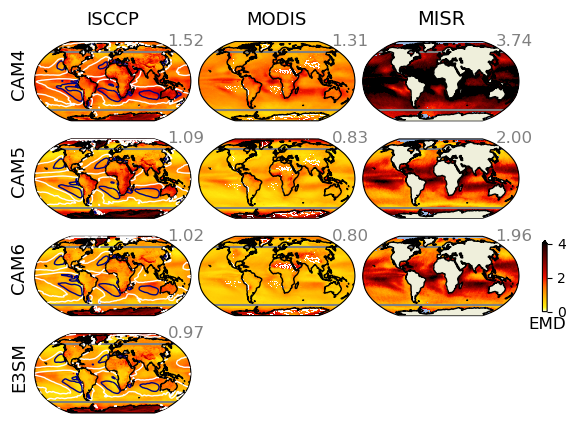

In [8]:
#
# Histogram Error Metric (set to 'relative_entropy' or 'EMD')
#
metric_name = 'EMD'
metric_string = 'EMD' # "$\mathcal{D}_{\mathrm{KL}}$"
proj = ccrs.Robinson()
fig, axs = plt.subplots(figsize=(6.25,5), ncols=3, nrows=4, subplot_kw={"projection":proj})
a1d = axs.ravel()
[a.coastlines(zorder=1001) for a in a1d]
[a.add_feature(cf.LAND, zorder=0) for a in a1d ]
[a.add_feature(cf.OCEAN, zorder=0) for a in a1d ]

opt = dict(norm = mpl.colors.Normalize(vmin=0, vmax=4), 
           cmap = cc.cm.fire_r, 
           rasterized=True, 
           shading='nearest', 
           zorder=0,
           lat_slice=slice(-60,60))

# cyc, cyclon = add_cyclic_point(c4_misr[metric_name], coord=c4_misr['lon'])
# lons, lats = np.meshgrid(c4_misr['lon'], c4_misr['lat'])

img1 = add_plot(axs[0,0], c4_isccp, metric_name, add_cyclic=True, **opt)
img2 = add_plot(axs[0,1], c4_modis, metric_name, add_cyclic=True, **opt)
img3 = add_plot(axs[0,2], c4_misr,  metric_name, add_cyclic=True, color_land=True, **opt)

img4 = add_plot(axs[1,0], c5_isccp, metric_name, **opt)
img5 = add_plot(axs[1,1], c5_modis, metric_name, add_cyclic=True, **opt)
img6 = add_plot(axs[1,2], c5_misr,  metric_name, add_cyclic=False, color_land=True, **opt)

img7 = add_plot(axs[2,0], c6_isccp, metric_name, **opt)
img8 = add_plot(axs[2,1], c6_modis, metric_name, add_cyclic=True, **opt)
img9 = add_plot(axs[2,2], c6_misr,  metric_name, add_cyclic=True, color_land=True, **opt)

img10 = add_plot(axs[3,0], e3_isccp,  metric_name, add_cyclic=True, color_land=False, **opt)

# lons, lats = np.meshgrid(e3_w5.lon, e3_w5.lat)
# zord = max([_.zorder for _ in axs[3,0].get_children()]) + 1
# axs[3,0].contour(lons, lats, e3_w5, levels=[25.346/864.,], transform=ccrs.PlateCarree(), zorder=zord)
add_contour(axs[0,0], c4_w5, levels=[0.0, 24.176/864.,])
add_contour(axs[1,0], c5_w5, levels=[0.0, 23.983/864.,])
add_contour(axs[2,0], c6_w5, levels=[0.0, 24.444/864.,])
add_contour(axs[3,0], e3_w5, levels=[0.0, 25.346/864.,])

fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb_c9_ax = inset_axes(axs[2,2],
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.15, 0.05, 1, 1),
                   bbox_transform=axs[2,2].transAxes,
                   borderpad=0
                   )
# cb = fig.colorbar(img9, cax=cb_c9_ax)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=opt['norm'], cmap=opt['cmap']), cax=cb_c9_ax,  extend='max')
# cb.set_label("$\mathcal{D}_{\mathrm{KL}}$", loc='bottom', rotation='horizontal', labelpad=-23, fontsize=13)
cb_c9_ax.text(1., -0.25, metric_string,  fontsize=12, ha='center', transform=cb_c9_ax.transAxes)

pos1 = axs[0,0].get_position().bounds
pos2 = axs[0,1].get_position().bounds
pos3 = axs[0,2].get_position().bounds

ypos1 = pos1
ypos2 = axs[1,0].get_position().bounds
ypos3 = axs[2,0].get_position().bounds
ypos4 = axs[3,0].get_position().bounds

fsize = 13

plt.text(pos1[0]+0.5*pos1[2], 0.9, "ISCCP", ha='center', fontsize=fsize, transform=fig.transFigure)
plt.text(pos2[0]+0.5*pos2[2], 0.9, "MODIS", ha='center', fontsize=fsize, transform=fig.transFigure)
plt.text(pos3[0]+0.5*pos3[2], 0.9, "MISR", fontsize=14, ha='center', transform=fig.transFigure)

plt.text(0.1, ypos1[1]+0.32*ypos1[-1], "CAM4", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)
plt.text(0.1, ypos2[1]+0.32*ypos2[-1], "CAM5", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)
plt.text(0.1, ypos3[1]+0.32*ypos3[-1], "CAM6", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)
plt.text(0.1, ypos4[1]+0.32*ypos4[-1], "E3SM", ha='center', fontsize=fsize, rotation=90, transform=fig.transFigure)

fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])

fig.savefig(f"/Users/brianpm/Dropbox/Projects/COSP2/combined_{metric_name}_maps_REVISED.pdf", bbox_inches='tight', dpi=300)


KeyError: 'frobenius_norm'

/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


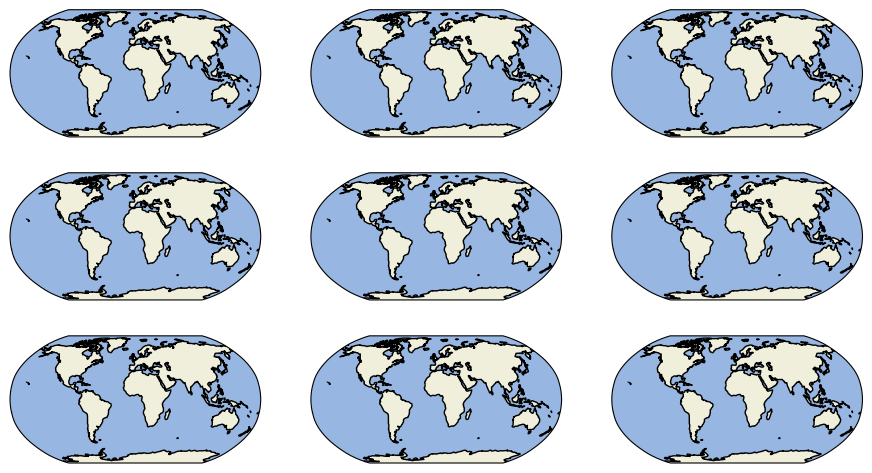

In [9]:
#
# This is the Froebenius Norm version, which is  holdover from experimentation with diffent metrics.
#
proj = ccrs.Robinson()
fig, axs = plt.subplots(figsize=(11,6), ncols=3, nrows=3, subplot_kw={"projection":proj})
a1d = axs.ravel()
[a.coastlines(zorder=1001) for a in a1d]
[a.add_feature(cf.LAND, zorder=0) for a in a1d ]
[a.add_feature(cf.OCEAN, zorder=0) for a in a1d ]
opt = dict(norm = mpl.colors.Normalize(vmin=0, vmax=2), cmap = cc.cm.fire_r, rasterized=True)


img1 = add_plot(axs[0,0], c4_isccp, 'frobenius_norm', **opt)
img2 = add_plot(axs[0,1], c4_modis, 'frobenius_norm', **opt)
img3 = add_plot(axs[0,2], c4_misr, 'frobenius_norm', add_cyclic=True, color_land=True, **opt)

img4 = add_plot(axs[1,0], c5_isccp, 'frobenius_norm', **opt)
img5 = add_plot(axs[1,1], c5_modis, 'frobenius_norm', **opt)
img6 = add_plot(axs[1,2], c5_misr, 'frobenius_norm', add_cyclic=True, color_land=True, **opt)

img7 = add_plot(axs[2,0], c6_isccp, 'frobenius_norm', **opt)
img8 = add_plot(axs[2,1], c6_modis, 'frobenius_norm', **opt)
img9 = add_plot(axs[2,2], c6_misr, 'frobenius_norm', add_cyclic=True, color_land=True, **opt)

fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb_c9_ax = inset_axes(axs[2,2],
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=axs[2,2].transAxes,
                   borderpad=0
                   )
# cb = fig.colorbar(img9, cax=cb_c9_ax)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=opt['norm'], cmap=opt['cmap']), cax=cb_c9_ax, extend='max')

# cb.set_label("$\mathcal{D}_{\mathrm{KL}}$", loc='bottom', rotation='horizontal', labelpad=-23, fontsize=13)
cb_c9_ax.text(1., -0.2, "$\mathcal{D}_{\mathrm{F}}$",  fontsize=13, ha='center', transform=cb_c9_ax.transAxes)

pos1 = axs[0,0].get_position().bounds
pos2 = axs[0,1].get_position().bounds
pos3 = axs[0,2].get_position().bounds

plt.text(pos1[0]+0.5*pos1[2], 0.9, "ISCCP", ha='center', fontsize=14, transform=fig.transFigure)
plt.text(pos2[0]+0.5*pos2[2], 0.9, "MODIS", ha='center', fontsize=14, transform=fig.transFigure)
plt.text(pos3[0]+0.5*pos3[2], 0.9, "MISR", fontsize=14, ha='center', transform=fig.transFigure)

plt.text(0.1, 0.735, "CAM4", fontsize=14, rotation=90, transform=fig.transFigure)
plt.text(0.1, 0.465, "CAM5", fontsize=14, rotation=90, transform=fig.transFigure)
plt.text(0.1, 0.205, "CAM6", fontsize=14, rotation=90, transform=fig.transFigure)

fig.savefig("/Users/brianpm/Dropbox/Projects/COSP2/combined_frobenius_maps.pdf", bbox_inches='tight', dpi=300)


In [ ]:
e3_isccp

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    EMD      (lat, lon) float64 ...